# Recommendation Systems Evolutionary Dynamics

## Imports

In [1]:
from recommendation_systems_evolutionary_dynamics import EGT
import numpy as np
import matplotlib.pylab as plt

## Initialize Game
1. Strategies counts for each populations (imiplicitly defining populations sizes)
2. actions names
3. players names
4. payoff matrix

In [2]:
strategies_counts = [[49, 1],[49, 1],[49, 1]]
actions_names = ["Defect", "Cooperate"]
players_names = ["Public", "Private", "Civil"]

#Payoff Matrix
paramss = [[0.15, 0.15, 0.4, 0.8, 0.2], [0.15, 0.15, 0.4, 0, 0.2], [0.2, 0.5, 0.6, 0, 0.3]]
params = paramss[0] 
cs = params[0]
ct = params[1]
bs = params[2]
br = params[3]
alpha = params[4]

payoff_matrix = {(0, 0, 0): [0, alpha, alpha],
                 (0, 0, 1): [0, 0, 0],
                 (0, 1, 0): [0, -ct, 0],
                 (0, 1, 1): [0, alpha - ct, alpha],
                 (1, 0, 0): [0, alpha, alpha],
                 (1, 0, 1): [br - cs, 0, bs],
                 (1, 1, 0): [-cs, bs - ct, 0],
                 (1, 1, 1): [br - 2*cs, alpha + bs - ct, alpha + bs]}

game = EGT.Game(strategies_counts=strategies_counts, payoff_matrix=payoff_matrix, actions_names=actions_names, players_names=players_names)

Ps = game.get_populations()
for i, P in enumerate(Ps):
    print(f"P{i}: {np.unique_counts(P)}")
print(game.get_payoff_matrix())

P0: UniqueCountsResult(values=array([0, 1]), counts=array([49,  1]))
P1: UniqueCountsResult(values=array([0, 1]), counts=array([49,  1]))
P2: UniqueCountsResult(values=array([0, 1]), counts=array([49,  1]))
{(0, 0, 0): [0, 0.2, 0.2], (0, 0, 1): [0, 0, 0], (0, 1, 0): [0, -0.15, 0], (0, 1, 1): [0, 0.05000000000000002, 0.2], (1, 0, 0): [0, 0.2, 0.2], (1, 0, 1): [0.65, 0, 0.4], (1, 1, 0): [-0.15, 0.25, 0], (1, 1, 1): [0.5, 0.45000000000000007, 0.6000000000000001]}


## Evolutionry Dynamics (Finite Populations)

### Moran Process

#### Birth_Death Async

In [3]:
steps = 20000
rep = 10

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "bd", sync=False, reps=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=rep//5)

Replicate: 2
Replicate: 4
Replicate: 6
Replicate: 8


##### Evolution Visualization

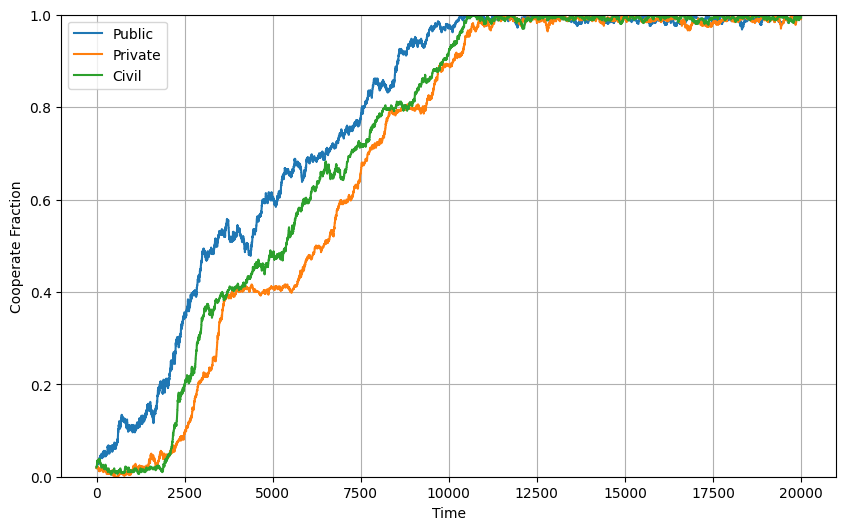

In [4]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction")

##### Stationary Distribution

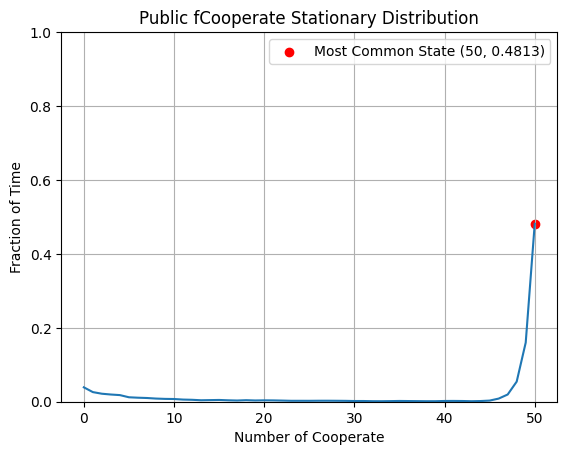

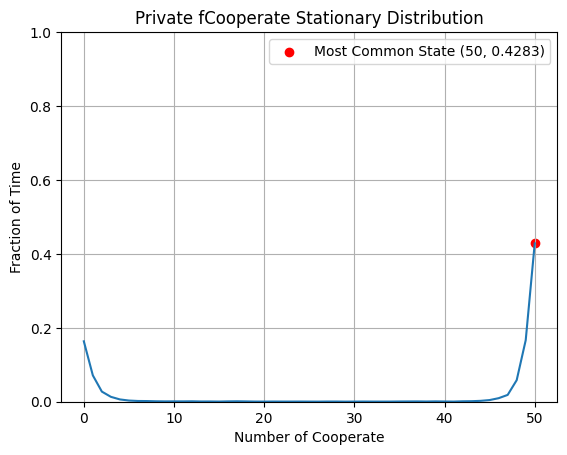

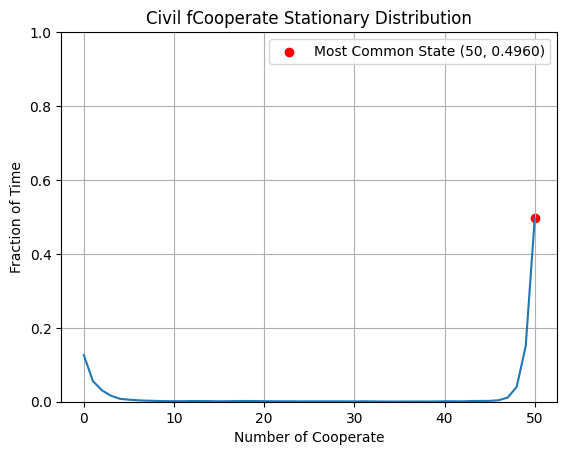

In [5]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution")

#### Birth_Death Sync

In [12]:
steps = 400
rep = 10

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "bd", sync=True, reps=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=rep//5)

Replicate: 2
Replicate: 4
Replicate: 6
Replicate: 8


##### Evolution Visualization

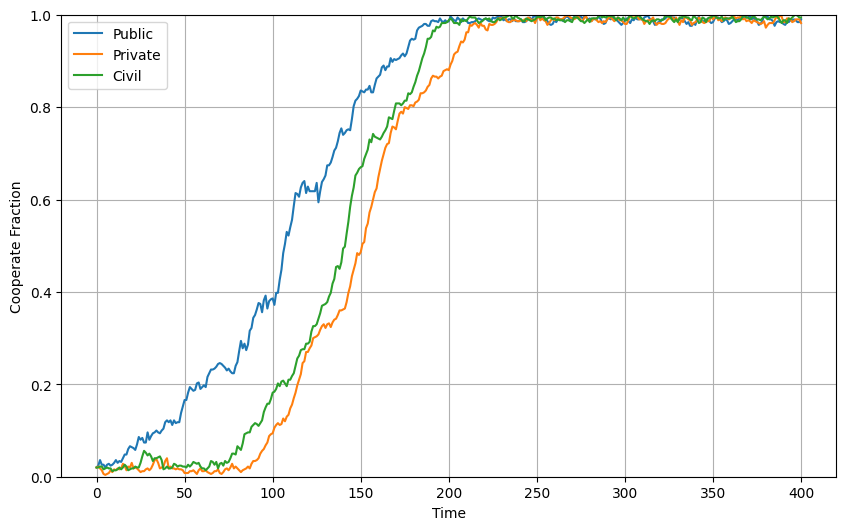

In [13]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction")

##### Stationary Distribution

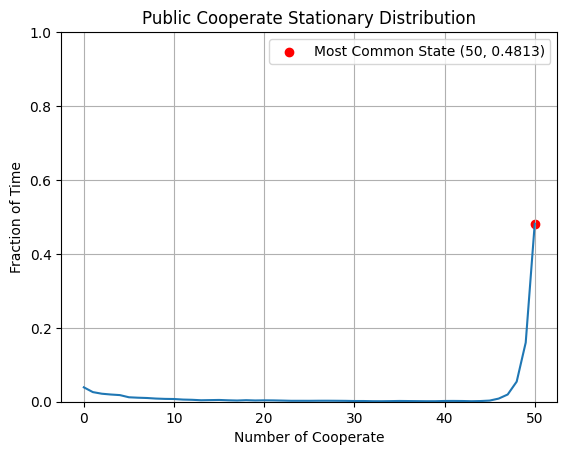

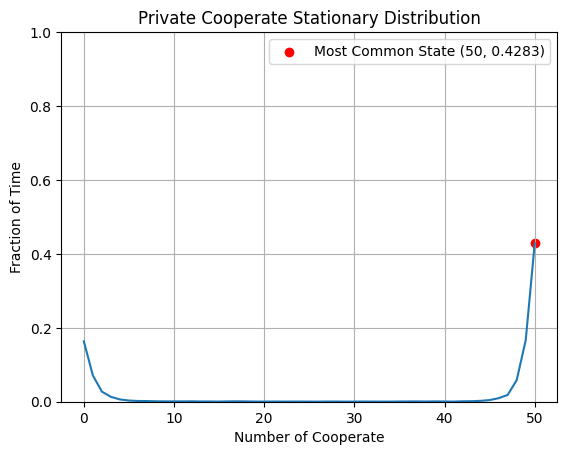

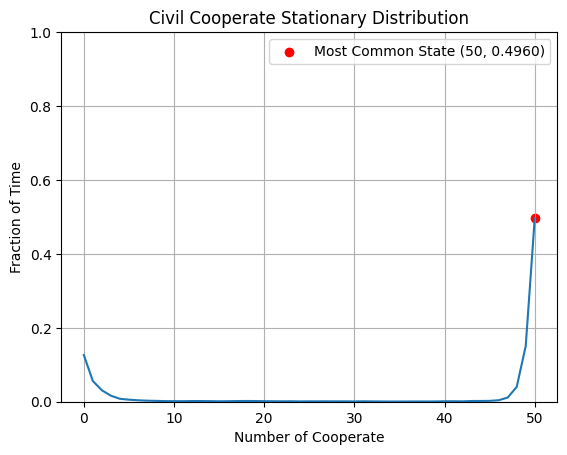

In [6]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution")

#### Death-Birth Async

In [ ]:
steps = 20000
rep = 10

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "db", sync=False, reps=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=rep//5)

##### Evolution Visualization

In [ ]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction")

##### Stationary Distribution

In [ ]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution")

#### Death-Birth Sync

In [ ]:
steps = 400
rep = 10

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "db", sync=True, reps=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=rep//5)

##### Evolution Visualization

In [ ]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction")

##### Stationary Distribution

In [ ]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution")

#### Pairwise Async

In [ ]:
steps = 20000
rep = 10

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "pairwise", sync=False, reps=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=rep//5)

##### Evolution Visualization

In [ ]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction")

##### Stationary Distribution

In [ ]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution")

#### Pairwise Sync

In [ ]:
steps = 400
rep = 10

mean_fractionss_hist, fractionss_hist, Ps_hist = game.moran_process(process = "pairwise", sync=True, reps=rep, steps=steps, beta=2.5, u=0.02, return_hist=True, print_rep_interval=rep//5)

##### Evolution Visualization

In [ ]:
action = 1
game.plot_strategy_evol(mean_fractionss_hist, action=action, xlabel="Time", ylabel=f"{actions_names[action]} Fraction")

##### Stationary Distribution

In [ ]:
action = 1
for player in range(len(players_names)):
    game.plot_stationary_dist(Ps_hist, player=player, action=action, xlabel=f"Number of {actions_names[action]}", ylabel="Fraction of Time" , title=f"{players_names[player]} {actions_names[action]} Stationary Distribution")

### Transition Matrix (Embedded Markov Chain)

In [3]:
matrix, states = game.compute_trans_matrix(beta=0.08)
matrix.shape
print(matrix)

[[0.96275037 0.00438682 0.00309807 0.00309807 0.00666667 0.00666667
  0.00666667 0.00666667]
 [0.00960808 0.90272806 0.00734085 0.00734085 0.01824554 0.01824554
  0.01824554 0.01824554]
 [0.01221641 0.01221641 0.94637996 0.00960808 0.00489479 0.00489479
  0.00489479 0.00489479]
 [0.00603427 0.00603427 0.00438682 0.92308104 0.0151159  0.0151159
  0.0151159  0.0151159 ]
 [0.00666667 0.00666667 0.00666667 0.00666667 0.94904355 0.00960808
  0.00734085 0.00734085]
 [0.00142749 0.00142749 0.00142749 0.00142749 0.00438682 0.96166179
  0.01412071 0.01412071]
 [0.0088125  0.0088125  0.0088125  0.0088125  0.00603427 0.00603427
  0.93550081 0.01718067]
 [0.0021292  0.0021292  0.0021292  0.0021292  0.0024197  0.0024197
  0.00163523 0.98500857]]


#### Embedded Markov Chain Visualization

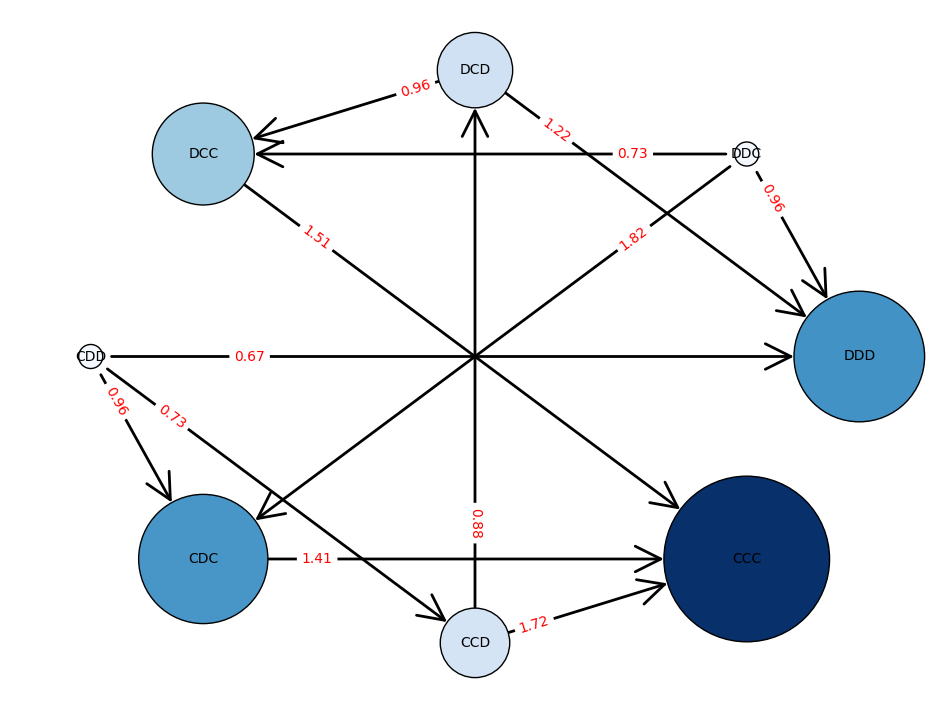

In [4]:
actions_symbols = ["D", "C"]
game.plot_transition_matrix(matrix, states=states, actions_symbols=actions_symbols, scale=100)

#### Stationary distrtibution from Transition Matrix 

In [5]:
stationary_distribution = game.compute_stationary_distribution(matrix)
stationary_distribution

array([0.10581846, 0.04122291, 0.06222019, 0.04838605, 0.09110888,
       0.12915068, 0.08830201, 0.43379083])

##### Visualize Stationary Distributions

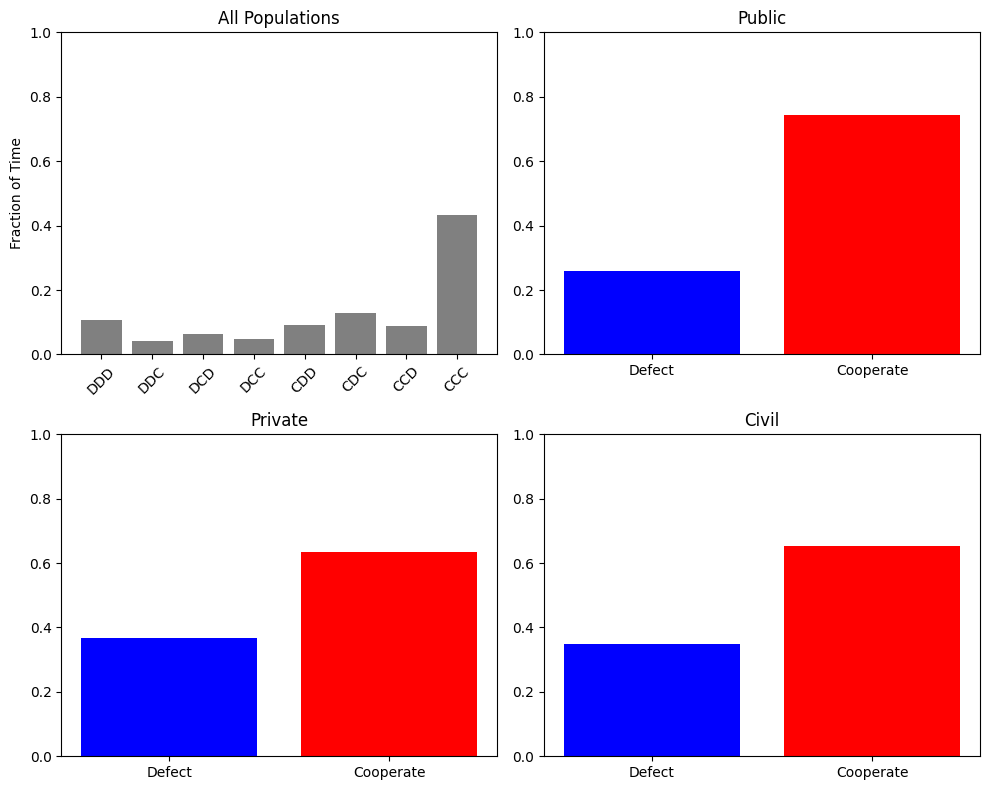

In [6]:
game.plot_stationary_distribution_bar_charts(stationary_distribution, actions_symbols=actions_symbols, states=states, ylabel="Fraction of Time")

## Evolutionary Dynamics (Infinite Populations)

### Replicator Dynamics

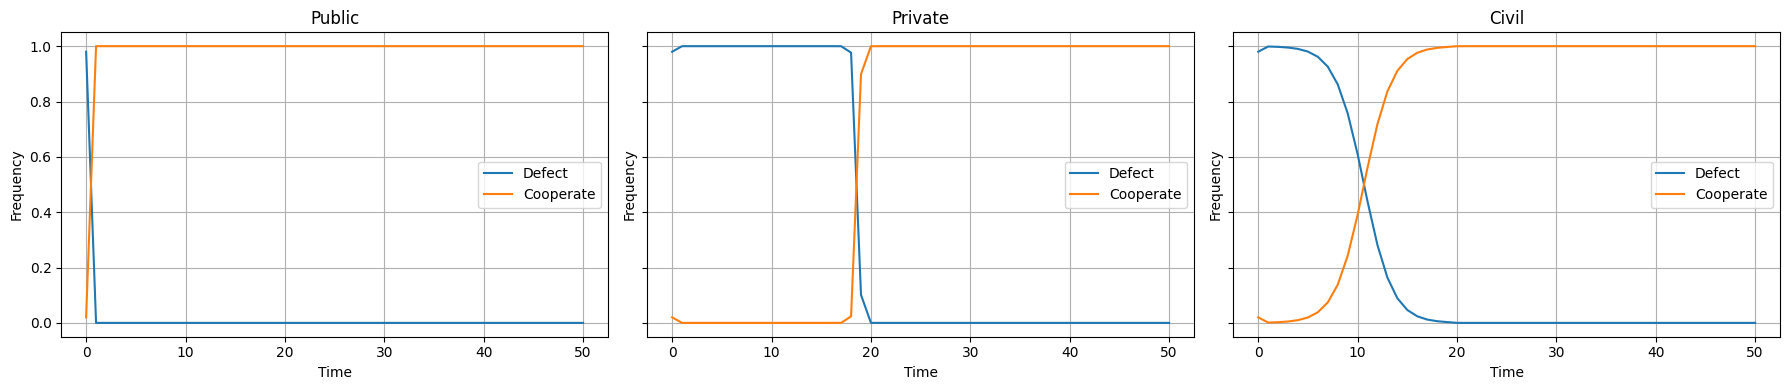

In [5]:
steps=50
fractions_hist = game.run_replicator_dynamics(steps=steps, players_names=["Public", "Private", "Civil"], actions_names=["Defect", "Cooperate"])

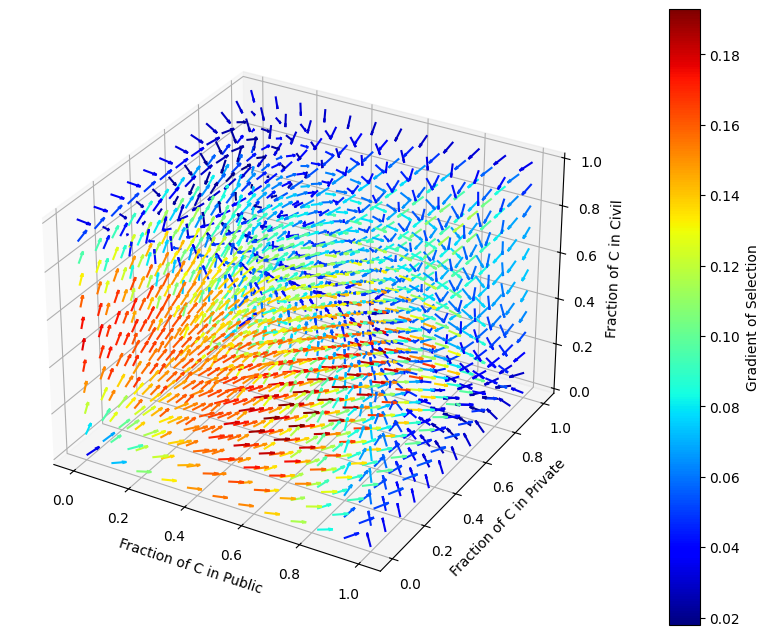

In [4]:
beta = 2.5 
u = 0.02
players_names = ["Public", "Private", "Civil"]
game.plot_gradient_field(beta, u, players_names=players_names, fraction_name="C", legend="Gradient of Selection")